# Setup S3 Buckets

In [5]:
import boto3
import sagemaker
import pandas as pd
from io import StringIO
from pyathena import connect
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import awswrangler as wr
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker import get_execution_role, Session
import io
from sagemaker.estimator import Estimator
from sagemaker import get_execution_role
from sagemaker.tuner import HyperparameterTuner, IntegerParameter, CategoricalParameter, ContinuousParameter
from sagemaker.model import Model, Transformer
import time



In [6]:
# List the S3 public bucket content
!aws s3 ls s3://ads508-group7/

                           PRE Arrest/
                           PRE Crime/
                           PRE Foreclosures/
                           PRE LAPD/
                           PRE Unsaved/
                           PRE combined_data/
                           PRE query-results/
                           PRE splits/
                           PRE xgb/
2025-03-15 21:02:43     546709 2023_Registered_Foreclosure_Properties.csv
2025-03-15 21:02:44     552165 2024_Registered_Foreclosure_Properties.csv
2025-03-15 21:40:42   92038326 Arrest_Data_from_2020_to_Present.csv
2025-03-15 21:40:42  255509498 Crime_Data_from_2020_to_Present.csv


In [7]:
# create sagemaker session
sess =  sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

s3 = boto3.client('s3')

In [8]:
# Set S3 Source Location (Public S3 Bucket)
s3_public_path = "s3://ads508-group7"

In [9]:
%store s3_public_path

Stored 's3_public_path' (str)


In [10]:
# Set S3 Destination Location (Private S3 Bucket)
s3_private_path = "s3://{}/ads508-group7".format(bucket)
print(s3_private_path)

s3://sagemaker-us-east-1-787322409522/ads508-group7


In [11]:
%store s3_private_path

Stored 's3_private_path' (str)


In [12]:
#Copy Data From the Public S3 Bucket to our Private S3 Bucket in this Account

In [13]:
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "2023_Registered_Foreclosure_Properties.csv"
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "2024_Registered_Foreclosure_Properties.csv"
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "Arrest_Data_from_2020_to_Present.csv"
!aws s3 cp --recursive $s3_public_path/ $s3_private_path/ --exclude "*" --include "Crime_Data_from_2020_to_Present.csv"

copy: s3://ads508-group7/2023_Registered_Foreclosure_Properties.csv to s3://sagemaker-us-east-1-787322409522/ads508-group7/2023_Registered_Foreclosure_Properties.csv
copy: s3://ads508-group7/2024_Registered_Foreclosure_Properties.csv to s3://sagemaker-us-east-1-787322409522/ads508-group7/2024_Registered_Foreclosure_Properties.csv
copy: s3://ads508-group7/Arrest_Data_from_2020_to_Present.csv to s3://sagemaker-us-east-1-787322409522/ads508-group7/Arrest_Data_from_2020_to_Present.csv
copy: s3://ads508-group7/Crime_Data_from_2020_to_Present.csv to s3://sagemaker-us-east-1-787322409522/ads508-group7/Crime_Data_from_2020_to_Present.csv


In [14]:
# List Files in our Private S3 Bucket in this Account
print(s3_private_path)

s3://sagemaker-us-east-1-787322409522/ads508-group7


In [15]:
!aws s3 ls $s3_private_path/

2025-04-10 03:27:06     546709 2023_Registered_Foreclosure_Properties.csv
2025-04-10 03:27:07     552165 2024_Registered_Foreclosure_Properties.csv
2025-04-10 03:27:09   92038326 Arrest_Data_from_2020_to_Present.csv
2025-04-10 03:27:12  255509498 Crime_Data_from_2020_to_Present.csv


In [16]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/sagemaker-{}-{}/ads508-group7/?region={}&tab=overview">S3 Bucket</a></b>'.format(
            region, account_id, region
        )
    )
)

/tmp/ipykernel_463/288684959.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [17]:
# store variables for the next notebook
%store

Stored variables and their in-db values:
s3_private_path                         -> 's3://sagemaker-us-east-1-787322409522/ads508-grou
s3_public_path                          -> 's3://ads508-group7'
setup_dependencies_passed               -> True
setup_instance_check_passed             -> True


# EDA

In [18]:
#create Data quality report function for continous data 

def dqr_cont(df): 
    # Identify continuous features based on numeric data types
    conf = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    # Create the report DataFrame
    report = pd.DataFrame({
        'Feature': conf,
        'Count': df[conf].count().values,
        'Missing Values': df[conf].isnull().sum().values,
        'Cardinality': df[conf].nunique().values,
        'Min': df[conf].min().values,
        '1st Quartile': df[conf].quantile(0.25).values,
        'Mean': df[conf].mean().values,
        'Median': df[conf].median().values,
        '3rd Quartile': df[conf].quantile(0.75).values,
        'Max': df[conf].max().values,
        'Standard Deviation': df[conf].std().values,
    }) 
    return report

In [19]:
#create data qualtiy report for categorical data
def dqr_cat(df):
    # Identify categorical features (object dtype)
    catf = df.select_dtypes(include=['object']).columns.tolist()
    
    # Initialize lists to store mode and frequency metrics for each categorical feature
    modes = []
    mode_freqs = []
    second_modes = []
    second_mode_freqs = []
    mode_percentages = []
    second_mode_percentages = []
    
    # Calculate metrics for each categorical feature
    for feature in catf:
        count = df[feature].count()
        # Compute mode and frequency of mode
        mode = df[feature].mode().iloc[0] if count > 0 else None
        mode_freq = df[feature].value_counts().iloc[0] if count > 0 else 0
        
        modes.append(mode)
        mode_freqs.append(mode_freq)
        mode_percentages.append((mode_freq / count) * 100 if count > 0 else 0)
        
        # Calculate second mode and its frequency if it exists
        value_counts = df[feature].value_counts()
        if len(value_counts) > 1:
            second_mode = value_counts.index[1]
            second_mode_freq = value_counts.iloc[1]
        else:
            second_mode = None
            second_mode_freq = 0
        
        second_modes.append(second_mode)
        second_mode_freqs.append(second_mode_freq)
        second_mode_percentages.append((second_mode_freq / count) * 100 if count > 0 else 0)
    
    # Build the quality report DataFrame
    report = pd.DataFrame({
        'Feature': catf,
        'Count': df[catf].count().values,
        'Missing Values': df[catf].isnull().sum().values,
        'Cardinality': df[catf].nunique().values,
        'Mode': modes,
        'Mode Frequency': mode_freqs,
        'Mode %': mode_percentages,
        '2nd Mode': second_modes,
        '2nd Mode Frequency': second_mode_freqs,
        '2nd Mode %': second_mode_percentages,
    })
    
    return report

## Arrest Data

In [20]:
# Read the Arrest CSV file directly from S3
df_arrest = wr.s3.read_csv("s3://ads508-group7/Arrest_Data_from_2020_to_Present.csv")

# Display the first few rows
df_arrest.head()

[04/10/25 03:27:14] INFO     Initializing a Ray instance                                               ]8;id=617270;file:///opt/conda/lib/python3.11/site-packages/awswrangler/distributed/ray/_core.py\_core.py]8;;\:]8;id=115039;file:///opt/conda/lib/python3.11/site-packages/awswrangler/distributed/ray/_core.py#202\202]8;;\

2025-04-10 03:27:15,728	WARNING services.py:2022 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 1895804928 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=4.65gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.
2025-04-10 03:27:15,889	INFO worker.py:1786 -- Started a local Ray instance.


,Report ID,Report Type,Arrest Date,Time,Area ID,Area Name,Reporting District,Age,Sex Code,Descent Code,...,Disposition Description,Address,Cross Street,LAT,LON,Location,Booking Date,Booking Time,Booking Location,Booking Location Code
0,6636966,BOOKING,07/06/2023 12:00:00 AM,2250.0,8,West LA,817,46,M,B,...,MISDEMEANOR COMPLAINT FILED,900 GAYLEY AV,NaN,34.0637,-118.4482,POINT (-118.4482 34.0637),07/07/2023 12:00:00 AM,143.0,METRO - JAIL DIVISION,4273.0
1,6637119,BOOKING,07/07/2023 12:00:00 AM,1000.0,3,Southwest,396,39,M,B,...,MISDEMEANOR COMPLAINT FILED,40TH PL,VERMONT,34.0100,-118.2915,POINT (-118.2915 34.01),07/07/2023 12:00:00 AM,1156.0,77TH ST,4212.0
2,6624479,BOOKING,06/15/2023 12:00:00 AM,1850.0,7,Wilshire,724,33,F,H,...,MISDEMEANOR COMPLAINT FILED,100 THE GROVE DR,NaN,34.0736,-118.3563,POINT (-118.3563 34.0736),06/15/2023 12:00:00 AM,2251.0,77TH ST,4212.0
3,6636128,BOOKING,07/05/2023 12:00:00 AM,1550.0,2,Rampart,218,30,F,B,...,MISDEMEANOR COMPLAINT FILED,1000 ECHO PARK AV,NaN,34.0741,-118.2590,POINT (-118.259 34.0741),07/05/2023 12:00:00 AM,1940.0,METRO - JAIL DIVISION,4273.0
4,6636650,BOOKING,07/06/2023 12:00:00 AM,1335.0,12,77th Street,1258,31,M,H,...,NaN,7800 S BROADWAY,NaN,33.9689,-118.2783,POINT (-118.2783 33.9689),07/06/2023 12:00:00 AM,1345.0,77TH ST,4212.0


### Basic Data Information

In [21]:
df_arrest.shape

(338332, 25)

In [22]:
# Check data set for duplicate records
df_arrest.duplicated().sum()

0

In [23]:
#get datatypes
df_arrest.dtypes

Report ID                     int64
Report Type                  object
Arrest Date                  object
Time                        float64
Area ID                       int64
Area Name                    object
Reporting District            int64
Age                           int64
Sex Code                     object
Descent Code                 object
Charge Group Code           float64
Charge Group Description     object
Arrest Type Code             object
Charge                       object
Charge Description           object
Disposition Description      object
Address                      object
Cross Street                 object
LAT                         float64
LON                         float64
Location                     object
Booking Date                 object
Booking Time                float64
Booking Location             object
Booking Location Code       float64
dtype: object

In [24]:
#convert date times stamps from object
df_arrest['Arrest Date'] = pd.to_datetime(df_arrest['Arrest Date'], format='%m/%d/%Y %I:%M:%S %p')
df_arrest['Booking Date'] = pd.to_datetime(df_arrest['Booking Date'], format='%m/%d/%Y %I:%M:%S %p')
print(f"Arrest Date dtype: {df_arrest['Arrest Date'].dtype}, Booking Date dtype:{df_arrest['Booking Date'].dtype} ")

Arrest Date dtype: datetime64[ns], Booking Date dtype:datetime64[ns] 


In [25]:
#only include dates from 2023 and 2024, and drop everything else in order to match timeline of the foreclosure data we have
df_a = df_arrest[(df_arrest['Arrest Date'] >= pd.Timestamp('1/01/2023')) &
                (df_arrest['Arrest Date'] < pd.Timestamp('2025-01-01'))]

df_a.shape

(135423, 25)

### Data Quality Report - Continous

In [26]:
pd.options.display.float_format = '{:.2f}'.format
cont_df_a = dqr_cont(df_a)
cont_df_a

,Feature,Count,Missing Values,Cardinality,Min,1st Quartile,Mean,Median,3rd Quartile,Max,Standard Deviation
0,Report ID,135423,0,135423,3365638.00,6670981.50,67158002.82,6808540.00,230209886.00,252004041.00,101217108.10
1,Time,135414,9,1437,1.00,905.00,1331.17,1400.00,1830.00,2400.00,633.92
2,Area ID,135423,0,21,1.00,3.00,10.09,10.00,15.00,21.00,6.45
3,Reporting District,135423,0,1220,101.00,399.00,1055.38,1065.00,1586.00,2197.00,644.70
4,Age,135423,0,93,0.00,27.00,35.69,34.00,43.00,94.00,12.31
5,Charge Group Code,118396,17027,28,1.00,6.00,13.22,12.00,22.00,29.00,7.61
6,LAT,135423,0,4264,0.00,34.02,34.08,34.06,34.17,34.33,0.36
7,LON,135423,0,4126,-118.67,-118.42,-118.34,-118.31,-118.27,0.00,1.21
8,Booking Time,99826,35597,1437,1.00,542.00,1269.61,1358.00,1931.00,2359.00,737.30
9,Booking Location Code,99826,35597,29,4201.00,4212.00,4252.72,4273.00,4279.00,4283.00,31.33


### Data Quality Report - Categorical

In [27]:
cat_df_a = dqr_cat(df_a)
cat_df_a

,Feature,Count,Missing Values,Cardinality,Mode,Mode Frequency,Mode %,2nd Mode,2nd Mode Frequency,2nd Mode %
0,Report Type,135423,0,2,BOOKING,99826,73.71,RFC,35597,26.29
1,Area Name,135423,0,21,Rampart,13580,10.03,Central,13367,9.87
2,Sex Code,135423,0,2,M,107945,79.71,F,27478,20.29
3,Descent Code,135423,0,16,H,68913,50.89,B,36612,27.04
4,Charge Group Description,118377,17046,27,Miscellaneous Other Violations,17881,15.11,Aggravated Assault,16488,13.93
5,Arrest Type Code,135423,0,7,M,61850,45.67,F,58769,43.40
6,Charge,135423,0,3067,273.5(A)PC,7527,5.56,23152(A)VC,7251,5.35
7,Charge Description,118396,17027,1072,CORPORAL INJURY ON SPOUSE/COHABITANT/ETC,7527,6.36,DRUNK DRIVING ALCOHOL/DRUGS,7210,6.09
8,Disposition Description,119864,15559,21,MISDEMEANOR COMPLAINT FILED,69813,58.24,FELONY COMPLAINT FILED,24601,20.52
9,Address,135423,0,25077,2200 W 6TH ST,2221,1.64,600 S ALVARADO ST,1965,1.45


In [28]:
pivot_area = df_a.pivot_table(index=['Area ID', 'Area Name'], values='Report ID', aggfunc='count').reset_index()
pivot_area

,Area ID,Area Name,Report ID
0,1,Central,13367
1,2,Rampart,13580
2,3,Southwest,6979
3,4,Hollenbeck,4372
4,5,Harbor,3720
5,6,Hollywood,7331
6,7,Wilshire,3680
7,8,West LA,3943
8,9,Van Nuys,7095
9,10,West Valley,4196


In [29]:
pivot_charge = df_a.pivot_table(index=['Charge Group Code', 'Charge Group Description'], values='Report ID', aggfunc='count').reset_index()
pivot_charge

,Charge Group Code,Charge Group Description,Report ID
0,1.00,Homicide,624
1,2.00,Rape,489
2,3.00,Robbery,4438
3,4.00,Aggravated Assault,16488
4,5.00,Burglary,2995
5,6.00,Larceny,8065
6,7.00,Vehicle Theft,5182
7,8.00,Other Assaults,11831
8,9.00,Forgery/Counterfeit,267
9,10.00,Fraud/Embezzlement,972


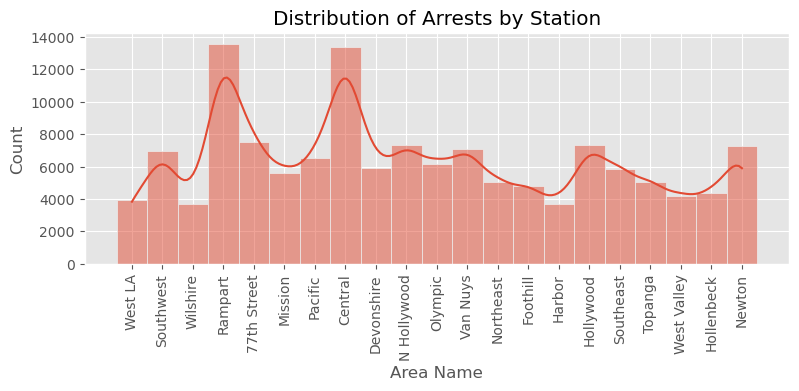

In [30]:
plt.style.use('ggplot')
plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
sns.histplot(df_a['Area Name'], kde = True)
plt.title('Distribution of Arrests by Station')
plt.xticks(rotation=90) 
plt.show()

## Crime Data

In [31]:
# Read the Crime CSV file directly from S3
df_crime = wr.s3.read_csv("s3://ads508-group7/Crime_Data_from_2020_to_Present.csv")

# Display the first few rows
df_crime.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,AA,Adult Arrest,510.00,998.00,NaN,NaN,1900 S LONGWOOD AV,NaN,34.04,-118.35
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,...,IC,Invest Cont,330.00,998.00,NaN,NaN,1000 S FLOWER ST,NaN,34.04,-118.26
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,...,IC,Invest Cont,480.00,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.02,-118.30
3,200907217,05/10/2023 12:00:00 AM,03/10/2020 12:00:00 AM,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),...,IC,Invest Cont,343.00,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.16,-118.44
4,200412582,09/09/2020 12:00:00 AM,09/09/2020 12:00:00 AM,630,4,Hollenbeck,413,1,510,VEHICLE - STOLEN,...,IC,Invest Cont,510.00,NaN,NaN,NaN,200 E AVENUE 28,NaN,34.08,-118.21


In [32]:
df_crime.shape

(1005104, 28)

In [33]:
# Check data set for duplicat records
df_crime.duplicated().sum()

0

In [34]:
df_crime.dtypes

DR_NO               int64
Date Rptd          object
DATE OCC           object
TIME OCC            int64
AREA                int64
AREA NAME          object
Rpt Dist No         int64
Part 1-2            int64
Crm Cd              int64
Crm Cd Desc        object
Mocodes            object
Vict Age            int64
Vict Sex           object
Vict Descent       object
Premis Cd         float64
Premis Desc        object
Weapon Used Cd    float64
Weapon Desc        object
Status             object
Status Desc        object
Crm Cd 1          float64
Crm Cd 2          float64
Crm Cd 3          float64
Crm Cd 4          float64
LOCATION           object
Cross Street       object
LAT               float64
LON               float64
dtype: object

In [35]:
# Convert date time stamps from object to datetime
df_crime['DATE OCC'] = pd.to_datetime(df_crime['DATE OCC'], format='%m/%d/%Y %I:%M:%S %p')

# will drop Date Rptd, and just use DATE OCC for the rest of the project
df_cr = df_crime.drop('Date Rptd', axis=1)

# Check the new dataframe shape and top rows
print(df_cr.shape)
print(df_cr.head())


(1005104, 27)
       DR_NO   DATE OCC  TIME OCC  AREA   AREA NAME  Rpt Dist No  Part 1-2  \
0  190326475 2020-03-01      2130     7    Wilshire          784         1   
1  200106753 2020-02-08      1800     1     Central          182         1   
2  200320258 2020-11-04      1700     3   Southwest          356         1   
3  200907217 2020-03-10      2037     9    Van Nuys          964         1   
4  200412582 2020-09-09       630     4  Hollenbeck          413         1   

   Crm Cd                               Crm Cd Desc         Mocodes  ...  \
0     510                          VEHICLE - STOLEN             NaN  ...   
1     330                     BURGLARY FROM VEHICLE  1822 1402 0344  ...   
2     480                             BIKE - STOLEN       0344 1251  ...   
3     343  SHOPLIFTING-GRAND THEFT ($950.01 & OVER)       0325 1501  ...   
4     510                          VEHICLE - STOLEN             NaN  ...   

   Status   Status Desc Crm Cd 1  Crm Cd 2 Crm Cd 3  Crm Cd 

In [36]:
#only include dates from 2023 and 2024, and drop everything else in order to match timeline of the foreclosure data we have
df_cr = df_cr[(df_cr['DATE OCC'] >= pd.Timestamp('1/01/2023')) &
                (df_cr['DATE OCC'] < pd.Timestamp('2025-01-01'))]

df_cr.shape

(359910, 27)

In [37]:
df_cr.head()

,DR_NO,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
644974,230611294,2023-06-17,1140,6,Hollywood,668,1,442,SHOPLIFTING - PETTY THEFT ($950 & UNDER),1822 0325 2004,...,IC,Invest Cont,442.00,NaN,NaN,NaN,5500 W SUNSET BL,NaN,34.10,-118.31
644975,230106843,2023-02-11,1630,1,Central,191,1,440,THEFT PLAIN - PETTY ($950 & UNDER),0913 0344 0603,...,IC,Invest Cont,440.00,NaN,NaN,NaN,1400 WRIGHT ST,NaN,34.04,-118.27
644976,231515059,2023-09-19,1030,15,N Hollywood,1549,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",1309 0421 0913 0334,...,IC,Invest Cont,230.00,761.00,NaN,NaN,BURBANK BL,CAHUENGA BL,34.17,-118.36
644977,230110347,2023-04-10,816,1,Central,192,1,331,THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND ...,0344 1822,...,IC,Invest Cont,331.00,NaN,NaN,NaN,1300 S FLOWER ST,NaN,34.04,-118.27
644978,230618504,2023-12-01,110,6,Hollywood,639,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,1202 1814 0913 0319 2001 1813 2000 0400 0448,...,AO,Adult Other,626.00,NaN,NaN,NaN,5400 RUSSELL AV,NaN,34.10,-118.31


### Data Quality Reports

In [38]:
#dqr continous
pd.options.display.float_format = '{:.2f}'.format
cont_df_cr = dqr_cont(df_cr)
cont_df_cr

,Feature,Count,Missing Values,Cardinality,Min,1st Quartile,Mean,Median,3rd Quartile,Max,Standard Deviation
0,DR_NO,359910,0,359910,2315.00,230818006.25,234796767.76,231710269.50,240706739.50,252104036.00,4920268.64
1,TIME OCC,359910,0,1439,1.00,911.00,1351.25,1430.00,1900.00,2359.00,645.10
2,AREA,359910,0,21,1.00,5.00,10.61,11.00,16.00,21.00,6.15
3,Rpt Dist No,359910,0,1164,101.00,564.00,1107.97,1132.00,1605.00,2199.00,615.78
4,Part 1-2,359910,0,2,1.00,1.00,1.37,1.00,2.00,2.00,0.48
5,Crm Cd,359910,0,138,110.00,331.00,498.04,442.00,626.00,956.00,199.77
6,Vict Age,359910,0,100,-1.00,0.00,26.89,28.00,43.00,99.00,22.43
7,Premis Cd,359902,8,304,101.00,101.00,306.76,203.00,501.00,976.00,224.53
8,Weapon Used Cd,102484,257426,77,101.00,312.00,367.80,400.00,400.00,516.00,123.93
9,Crm Cd 1,359906,4,141,110.00,331.00,497.85,442.00,626.00,956.00,199.60


In [39]:
#dqr categorical
cat_df_cr = dqr_cat(df_cr)
cat_df_cr

,Feature,Count,Missing Values,Cardinality,Mode,Mode Frequency,Mode %,2nd Mode,2nd Mode Frequency,2nd Mode %
0,AREA NAME,359910,0,21,Central,27182,7.55,Pacific,21950,6.10
1,Crm Cd Desc,359910,0,138,VEHICLE - STOLEN,45982,12.78,BATTERY - SIMPLE ASSAULT,24233,6.73
2,Mocodes,296680,63230,108880,0344,15640,5.27,1822 0344,7075,2.38
3,Vict Sex,299216,60694,5,M,134952,45.10,F,119091,39.80
4,Vict Descent,299208,60702,20,H,97973,32.74,W,67578,22.59
5,Premis Desc,359631,279,297,STREET,99459,27.66,SINGLE FAMILY DWELLING,53319,14.83
6,Weapon Desc,102484,257426,77,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",53756,52.45,UNKNOWN WEAPON/OTHER WEAPON,13340,13.02
7,Status,359909,1,6,IC,299319,83.17,AO,31957,8.88
8,Status Desc,359910,0,6,Invest Cont,299319,83.16,Adult Other,31957,8.88
9,LOCATION,359910,0,49927,800 N ALAMEDA ST,1428,0.40,11800 SANTA MONICA BL,1202,0.33


In [40]:
# Group and count crimes by station
crime_by_station = df_cr.groupby('AREA NAME').size().reset_index(name='Crime Count')

# Sort in descending order 
crime_by_station = crime_by_station.sort_values(by='Crime Count', ascending=False)

# Display result
crime_by_station



,AREA NAME,Crime Count
1,Central,27182
12,Pacific,21950
15,Southwest,21420
0,77th Street,20727
8,N Hollywood,18806
20,Wilshire,18015
6,Hollywood,17601
11,Olympic,17525
9,Newton,17320
13,Rampart,17131


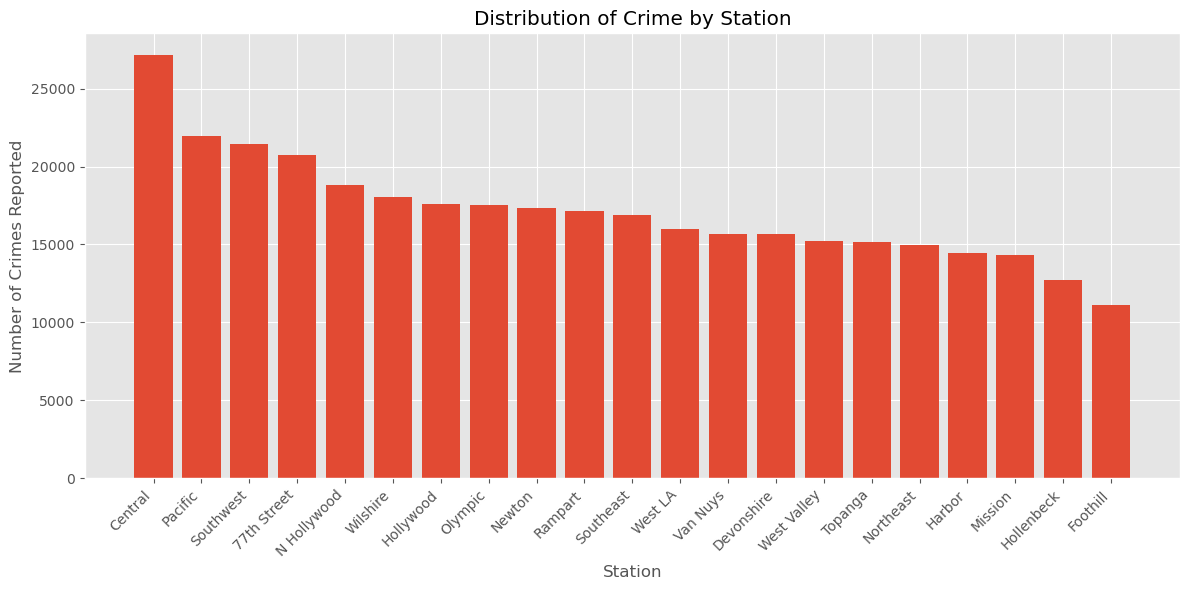

In [41]:
plt.figure(figsize=(12, 6))
plt.bar(crime_by_station['AREA NAME'], crime_by_station['Crime Count'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Station')
plt.ylabel('Number of Crimes Reported')
plt.title('Distribution of Crime by Station')
plt.tight_layout()
plt.show()

## Foreclosure Data

In [42]:
# Read the Foreclosure CSV file directly from S3 2023 data
df_fc2023 = wr.s3.read_csv("s3://ads508-group7/2023_Registered_Foreclosure_Properties.csv")

# Display the first few rows
df_fc2023.head()

,APN,Registered Date,Property Type,Property Address,Property City,Property State,Property Zip,Council District,Lender,Lender Contact,Lender Contact Phone,Property Management,Property Management Contact,Property Management Address,Property Management Contact Phone,lon,lat,Property on map
0,2005012003,10/19/2023,Single Family,8361 N WOODLAKE AVE,LOS ANGELES,CA,91304,12,HML Investments,Cynthia Rivera,818-308-4443,ZVN Properties Inc,Arek Helcberger,957 E Cherry ST Canal Fulton OH 44614,330-854-5890,-118.63,34.22,POINT (-118.63231 34.22141)
1,2005018009,01/11/2023,Single Family,8349 N HILLARY DR,LOS ANGELES,CA,93063,12,Select Portfolio Servicing,Select Portfolio Servicing,888-349-8964,edward zubia,Edward Zubia,3540 willshire BLVD los angeles CA 90010,213-804-7437,-118.64,34.22,POINT (-118.64078 34.221)
2,2010005010,02/07/2023,Single Family,21811 W GRESHAM ST,LOS ANGELES,CA,93063,12,Fay Servicing,Eric Moore,877-338-3791,Safeguard,Code Compliance,7887 Safeguard Cir Valley View OH 44125,800-852-8306,-118.60,34.23,POINT (-118.60343 34.23144)
3,2010009038,09/12/2023,Single Family,21938 W LONDELIUS ST,LOS ANGELES,CA,91304,12,NEW AMERICAN FUNDING,KARLA HOWES,949-445-8824,SO CAL INSPECTORS INC,SUZANNE PHILLIPS,9525 Stewart and Gray RD Downey CA 90241,949-445-8824,-118.61,34.23,POINT (-118.60575 34.22912)
4,2010010027,10/18/2023,Single Family,22151 W PARTHENIA ST,LOS ANGELES,CA,93063,12,Specialized Loan Servicing LLC on behalf of be...,Douglas Randall,720-563-8186,Genstone Realty,Mark Giltner,15338 Central AVE Chino CA 91710,909-261-5415,-118.61,34.23,POINT (-118.60936 34.22832)


In [43]:
df_fc2023.shape

(2080, 18)

In [44]:
# Check data set for duplicate records
df_fc2023.duplicated().sum()

0

In [45]:
df_fc2023.dtypes

APN                                    int64
Registered Date                       object
Property Type                         object
Property Address                      object
Property City                         object
Property State                        object
Property Zip                           int64
Council District                       int64
Lender                                object
Lender Contact                        object
Lender Contact Phone                  object
Property Management                   object
Property Management Contact           object
Property Management Address           object
Property Management Contact Phone     object
lon                                  float64
lat                                  float64
Property on map                       object
dtype: object

In [46]:
#dqr contin, 2023
pd.options.display.float_format = '{:.2f}'.format
cont_df_23 = dqr_cont(df_fc2023)
cont_df_23

,Feature,Count,Missing Values,Cardinality,Min,1st Quartile,Mean,Median,3rd Quartile,Max,Standard Deviation
0,APN,2080,0,1910,2005012003.00,2527010020.00,4088322295.99,4313008024.50,5432033272.75,7559039036.00,1585625055.47
1,Property Zip,2080,0,115,90001.00,90037.00,90661.57,90210.00,91342.00,99999.00,760.13
2,Council District,2080,0,15,1.00,4.00,8.03,8.00,12.00,15.00,4.00
3,lon,2080,0,1831,-118.66,-118.47,-118.39,-118.38,-118.29,-118.16,0.11
4,lat,2080,0,1819,33.71,34.00,34.10,34.10,34.21,34.33,0.13


In [47]:
#dqr categorical 2023
cat_df_23 = dqr_cat(df_fc2023)
cat_df_23

,Feature,Count,Missing Values,Cardinality,Mode,Mode Frequency,Mode %,2nd Mode,2nd Mode Frequency,2nd Mode %
0,Registered Date,2080,0,249,01/03/2023,161,7.74,01/11/2023,78,3.75
1,Property Type,2080,0,4,Single Family,1681,80.82,Multi-Family,371,17.84
2,Property Address,2080,0,1885,1735 FULLER AVE,4,0.19,1735 FULLER AVE,4,0.19
3,Property City,2080,0,29,LOS ANGELES,1916,92.12,VAN NUYS,42,2.02
4,Property State,2080,0,1,CA,2080,100.00,None,0,0.00
5,Lender,2078,2,351,Specialized Loan Servicing LLC C/O Computersha...,154,7.41,Select Portfolio Servicing,135,6.50
6,Lender Contact,2080,0,285,Eric Moore,464,22.31,Select Portfolio Servicing,181,8.70
7,Lender Contact Phone,2080,0,258,877-338-3791,473,22.74,888-349-8964,200,9.62
8,Property Management,1921,159,187,Edward Zubia,175,9.11,SFP,167,8.69
9,Property Management Contact,1922,158,174,Code Compliance,301,15.66,Dehavillyn Mack,170,8.84


In [48]:
# Read the Foreclosure CSV file directly from S3, 2024 data
df_fc2024 = wr.s3.read_csv("s3://ads508-group7/2024_Registered_Foreclosure_Properties.csv")

# Display the first few rows
df_fc2024.head()

,APN,Registered Date,Property Type,PropertyAddress,PropertyCity,PropertyState,PropertyZip,CouncilDistrict,Lender,LenderContact,LenderContactPhone,PropertyManagement,PropertyManagementContact,PropertyManagementAddress,PropertyMgmtContactPhone,lon,lat,Property map
0,2010010029,2024-07-31T00:00:00.000,Single Family,22171 W PARTHENIA ST,LOS ANGELES,CA,91304,12,BSI Financial Services,Registration Department,814-827-4661,Elliott J Services LLC,Elliott Ramirez,242 E Cottonwood ST 1 ONTARIO CA 91761,909-262-4175,-118.61,34.23,POINT (-118.60975 34.22866)
1,2010005010,2024-02-05T00:00:00.000,Single Family,21811 W GRESHAM ST,LOS ANGELES,CA,93063,12,Fay Servicing LLC,Eric Moore,877-338-3791,Safeguard,Code Compliance,27720 Jefferson AVE Temecula CA 92590,877-338-3791,-118.60,34.23,POINT (-118.60343 34.23144)
2,2023021019,2024-01-04T00:00:00.000,Single Family,22314 W COHASSET ST,LOS ANGELES,CA,91303,3,Shellpoint Mortgage Servicing,Eric Moore,877-338-3791,Guardian,Code Compliance,27720 CA AVE 230 Temecula CA 92590,877-338-3791,-118.61,34.21,POINT (-118.61295 34.2065)
3,2012003020,2024-09-27T00:00:00.000,Single Family,22146 W CANTARA ST,LOS ANGELES,CA,93063,3,Mr Cooper,Paula Acosta,888-456-0714,"New Beginning Properties, Inc.",Jose Chavez,445 W 34th ST San Bernardino CA 92405,877-339-8202,-118.61,34.22,POINT (-118.60987 34.21779)
4,2042006081,2024-11-15T00:00:00.000,Single Family,23029 W DEL VALLE ST,LOS ANGELES,CA,91364,3,Shellpoint Mortgage Servicing,Eric Moore,877-338-3791,ServiceLink,Code Compliance,27720 CA AVE 230 Temecula CA 92590,877-338-3791,-118.63,34.16,POINT (-118.62703 34.16393)


In [49]:
df_fc2024.shape

(2009, 18)

In [50]:
# Check data set for duplicate records
df_fc2024.duplicated().sum()

0

In [51]:
df_fc2024.dtypes

APN                            int64
Registered Date               object
Property Type                 object
PropertyAddress               object
PropertyCity                  object
PropertyState                 object
PropertyZip                    int64
CouncilDistrict                int64
Lender                        object
LenderContact                 object
LenderContactPhone            object
PropertyManagement            object
PropertyManagementContact     object
PropertyManagementAddress     object
PropertyMgmtContactPhone      object
lon                          float64
lat                          float64
Property map                  object
dtype: object

In [52]:
#dqr contin, 2024
pd.options.display.float_format = '{:.2f}'.format
cont_df_24 = dqr_cont(df_fc2024)
cont_df_24

,Feature,Count,Missing Values,Cardinality,Min,1st Quartile,Mean,Median,3rd Quartile,Max,Standard Deviation
0,APN,2009,0,1869,2005016015.00,2532010072.00,4108194019.91,4325006093.00,5419028030.00,7560013046.00,1567469259.38
1,PropertyZip,2009,0,115,90001.00,90037.00,90642.63,90077.00,91342.00,99999.00,739.80
2,CouncilDistrict,2009,0,15,1.00,4.00,8.11,8.00,12.00,15.00,3.97
3,lon,2009,0,1794,-118.66,-118.47,-118.39,-118.37,-118.30,-118.16,0.11
4,lat,2009,0,1793,33.71,34.00,34.10,34.09,34.20,34.33,0.13


In [53]:
#dqr categorical 2024
cat_df_24 = dqr_cat(df_fc2024)
cat_df_24

,Feature,Count,Missing Values,Cardinality,Mode,Mode Frequency,Mode %,2nd Mode,2nd Mode Frequency,2nd Mode %
0,Registered Date,2009,0,286,2024-01-04T00:00:00.000,117,5.82,2024-01-08T00:00:00.000,59,2.94
1,Property Type,2009,0,4,Single Family,1609,80.09,Multi-Family,337,16.77
2,PropertyAddress,2009,0,1847,5460 N WHITE OAK AVE,5,0.25,10701 WILSHIRE,4,0.20
3,PropertyCity,2008,1,28,LOS ANGELES,1846,91.93,HOLLYWOOD,44,2.19
4,PropertyState,2009,0,1,CA,2009,100.00,None,0,0.00
5,Lender,2009,0,343,Shellpoint Mortgage Servicing,248,12.34,Select Portfolio Servicing,169,8.41
6,LenderContact,2009,0,296,Eric Moore,669,33.30,Select Portfolio Servicing,190,9.46
7,LenderContactPhone,2009,0,282,877-338-3791,673,33.50,888-349-8964,206,10.25
8,PropertyManagement,1877,132,227,Edward Zubia,160,8.52,Guardian Asset Management,137,7.30
9,PropertyManagementContact,1879,130,188,Code Compliance,693,36.88,Edward Zubia,127,6.76


# Feature Engineering

## Transformations on Crime DF

In [54]:
# drop any other variables we've deemed irrelevant for our project
df_cr_mod = df_cr.drop(
    ['TIME OCC', 'AREA NAME', 'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes', 'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc', 
                 'Status', 'Status Desc', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'Weapon Used Cd',	'Weapon Desc', 'LAT', 'LON'], axis=1)

In [55]:
df_cr_mod.head()

,DR_NO,DATE OCC,AREA
644974,230611294,2023-06-17,6
644975,230106843,2023-02-11,1
644976,231515059,2023-09-19,15
644977,230110347,2023-04-10,1
644978,230618504,2023-12-01,6


In [56]:
# we then want to aggregate the df into a rolled up count of incidents by date and LAPD station ID
df_crime_agg = df_cr_mod.groupby(['DATE OCC', 'AREA']).size().reset_index(name='Total Crimes')

# Rename columns to match format
df_crime_agg.rename(columns={'DATE OCC': 'Date Occurred', 'AREA': 'Area ID'}, inplace=True)
print(df_crime_agg.head())

  Date Occurred  Area ID  Total Crimes
0    2023-01-01        1            68
1    2023-01-01        2            49
2    2023-01-01        3            67
3    2023-01-01        4            50
4    2023-01-01        5            48


## Transformations on Arrest DF

In [57]:
# drop any other variables we've deemed irrelevant for our project
df_a_mod = df_a.drop(
    ['Report Type', 'Time', 'Area Name', 'Reporting District', 'Age', 'Sex Code', 'Descent Code', 'Charge Group Code', 'Charge Group Description', 
     'Arrest Type Code', 'Charge', 'Charge Description', 'Disposition Description', 'Address', 'Cross Street', 'Location', 'Booking Date', 'Booking Time',
     'Booking Location', 'Booking Location Code', 'LAT', 'LON'], axis=1)

In [58]:
df_a_mod.head()

,Report ID,Arrest Date,Area ID
0,6636966,2023-07-06,8
1,6637119,2023-07-07,3
2,6624479,2023-06-15,7
3,6636128,2023-07-05,2
4,6636650,2023-07-06,12


In [59]:
# we then want to aggregate the df into a rolled up count of incidents by date and LAPD station ID
df_arrest_agg = df_a_mod.groupby(['Arrest Date', 'Area ID']).size().reset_index(name='Total Arrests')

# Rename columns to match the desired format
df_arrest_agg.rename(columns={'Arrest Date': 'Arrest Date', 'Area ID': 'Area ID'}, inplace=True)

# Display the first few rows
print(df_arrest_agg.head())

  Arrest Date  Area ID  Total Arrests
0  2023-01-01        1             10
1  2023-01-01        2              4
2  2023-01-01        3              9
3  2023-01-01        4              7
4  2023-01-01        5              5


## Transformations on Foreclosure DFs

In [60]:
# Foreclosure 2023
# drop any variables we've deemed irrelevant for our project
df_fc2023_mod = df_fc2023.drop(
    ['Property Address', 'Property City', 'Property State', 'Council District', 'Lender', 'Lender Contact', 'Lender Contact Phone', 'Property Management', 
     'Property Management Contact',	'Property Management Address', 'Property Management Contact Phone', 'Property on map', 'lon', 'lat', 'Property Type'], axis=1)

In [61]:
df_fc2023_mod.head()

,APN,Registered Date,Property Zip
0,2005012003,10/19/2023,91304
1,2005018009,01/11/2023,93063
2,2010005010,02/07/2023,93063
3,2010009038,09/12/2023,91304
4,2010010027,10/18/2023,93063


In [62]:
# Foreclosure 2024
# drop any variables we've deemed irrelevant for our project
df_fc2024_mod = df_fc2024.drop(
    ['PropertyAddress',	'PropertyCity',	'PropertyState', 'CouncilDistrict',	'Lender', 'LenderContact', 'LenderContactPhone', 'PropertyManagement', 
     'PropertyManagementContact', 'PropertyManagementAddress', 'PropertyMgmtContactPhone', 'Property map', 'lon', 'lat', 'Property Type'], axis=1)

In [63]:
df_fc2024_mod.head()

,APN,Registered Date,PropertyZip
0,2010010029,2024-07-31T00:00:00.000,91304
1,2010005010,2024-02-05T00:00:00.000,93063
2,2023021019,2024-01-04T00:00:00.000,91303
3,2012003020,2024-09-27T00:00:00.000,93063
4,2042006081,2024-11-15T00:00:00.000,91364


In [64]:
df_fc2023_mod.dtypes

APN                 int64
Registered Date    object
Property Zip        int64
dtype: object

In [65]:
df_fc2024_mod.dtypes

APN                 int64
Registered Date    object
PropertyZip         int64
dtype: object

In [66]:
# Convert Property Zip from int64 to string to avoid losing any leading 0
df_fc2023_mod['Property Zip'] = df_fc2023_mod['Property Zip'].astype(str)
df_fc2024_mod['PropertyZip'] = df_fc2024_mod['PropertyZip'].astype(str)

In [67]:
# Rename the column to 'Property Zip' for uniformity
df_fc2024_mod = df_fc2024_mod.rename(columns={'PropertyZip': 'Property Zip'})

In [68]:
# revise 2024 and 2023 Registered Date format to match

# Convert the "Registered Date" in df_fc2024_mod to datetime
df_fc2024_mod['Registered Date'] = pd.to_datetime(df_fc2024_mod['Registered Date'], errors='coerce')

# Convert the "Registered Date" in df_fc2023_mod to datetime
df_fc2023_mod['Registered Date'] = pd.to_datetime(df_fc2023_mod['Registered Date'], format='%m/%d/%Y', errors='coerce')

In [69]:
# Verify that both DataFrames now have the correct datetime format
print(df_fc2024_mod['Registered Date'].head())
print(df_fc2023_mod['Registered Date'].head())

0   2024-07-31
1   2024-02-05
2   2024-01-04
3   2024-09-27
4   2024-11-15
Name: Registered Date, dtype: datetime64[ns]
0   2023-10-19
1   2023-01-11
2   2023-02-07
3   2023-09-12
4   2023-10-18
Name: Registered Date, dtype: datetime64[ns]


In [70]:
print(df_fc2023_mod.shape)

(2080, 3)


In [71]:
print(df_fc2024_mod.shape)

(2009, 3)


In [72]:
# combine the two Foreclosure DataFrames
df_fc_combined = pd.concat([df_fc2023_mod, df_fc2024_mod], ignore_index=True)

In [73]:
# Verify the combined DataFrame
print(df_fc_combined.shape)
print(df_fc_combined.head(10))

(4089, 3)
          APN Registered Date Property Zip
0  2005012003      2023-10-19        91304
1  2005018009      2023-01-11        93063
2  2010005010      2023-02-07        93063
3  2010009038      2023-09-12        91304
4  2010010027      2023-10-18        93063
5  2012015011      2023-02-09        93063
6  2012016011      2023-07-17        93063
7  2013012024      2023-03-17        91304
8  2013012024      2023-06-28        91304
9  2013025018      2023-01-04        91304


In [74]:
# we are seeing duplicates in the APN (Assessor's Parcel Number, so we want to investigate further
unique_apn_count = df_fc_combined['APN'].nunique()
print("Number of unique APN values:", unique_apn_count)

# Sort the dataframe by APN and Foreclosure Date
df_fc_combined_sorted = df_fc_combined.sort_values(by=['APN', 'Registered Date'])

# Find duplicates based on APN
duplicates_sorted = df_fc_combined_sorted[df_fc_combined_sorted.duplicated(subset=['APN'], keep=False)]

# Display the sorted duplicates
duplicates_sorted.head(20)

Number of unique APN values: 3082


,APN,Registered Date,Property Zip
2,2010005010,2023-02-07,93063
2081,2010005010,2024-02-05,93063
7,2013012024,2023-03-17,91304
8,2013012024,2023-06-28,91304
2113,2013012024,2024-01-16,91304
2109,2013012024,2024-09-26,91304
16,2020009034,2023-01-25,91304
17,2020009034,2023-07-07,91304
2153,2020009034,2024-01-10,91304
19,2022008002,2023-07-08,91307


In [75]:
# it seems unlikely the same house would be foreclosed on more than one in a two year span and perhaps is how LA tracks the foreclosure process
# we will drop duplicate APNs and only keep the oldest Registered Date

# Sort the dataframe by APN and Registered Date (oldest date first)
df_fc_combined_sorted = df_fc_combined.sort_values(by=['APN', 'Registered Date'])

# Remove duplicates based on APN, keeping the first (oldest) row
df_fc_combined_no_duplicates = df_fc_combined_sorted.drop_duplicates(subset=['APN'], keep='first')

# Display the result
unique_apn_count = df_fc_combined_no_duplicates['APN'].nunique()
print("Number of unique APN values:", unique_apn_count)
print(df_fc_combined_no_duplicates.shape)
df_fc_combined_no_duplicates.head(10)

Number of unique APN values: 3082
(3082, 3)


,APN,Registered Date,Property Zip
0,2005012003,2023-10-19,91304
2107,2005016015,2024-05-13,91304
1,2005018009,2023-01-11,93063
2111,2005018029,2024-06-18,93063
2,2010005010,2023-02-07,93063
3,2010009038,2023-09-12,91304
4,2010010027,2023-10-18,93063
2080,2010010029,2024-07-31,91304
2088,2012003003,2024-02-21,93063
2083,2012003020,2024-09-27,93063


In [76]:
# next we have LAPD data on zip codes and what Area ID they correspond to, so we will combine that information

bucket_name = 'ads508-group7'
file_key = 'LAPD/LAPD Area ID v2.csv' 

# Download the file from S3 to a pandas DataFrame
obj = s3.get_object(Bucket=bucket_name, Key=file_key)
df_lapd = pd.read_csv(obj['Body'])

# Display the first few rows 
print(df_lapd.head())

   Area ID    Zip
0       18  90001
1       18  90002
2       12  90003
3       20  90004
4       20  90005


In [77]:
# Ensure they are in string format using .loc to avoid SettingWithCopyWarning
df_fc_combined_no_duplicates.loc[:, 'Property Zip'] = df_fc_combined_no_duplicates['Property Zip'].astype(str)
df_lapd.loc[:, 'Zip'] = df_lapd['Zip'].astype(str)

# Merge the dataframes
df_fc_lapd = pd.merge(df_fc_combined_no_duplicates, df_lapd[['Area ID', 'Zip']], left_on='Property Zip', right_on='Zip', how='left')

# Rename columns to match the desired output format
df_fc_lapd = df_fc_lapd.rename(columns={'Registered Date': 'Foreclosure Date', 'Property Zip': 'Zip Code'})

# Display the first few rows
print(df_fc_lapd.head(20))

           APN Foreclosure Date Zip Code  Area ID    Zip
0   2005012003       2023-10-19    91304    21.00  91304
1   2005016015       2024-05-13    91304    21.00  91304
2   2005018009       2023-01-11    93063      NaN    NaN
3   2005018029       2024-06-18    93063      NaN    NaN
4   2010005010       2023-02-07    93063      NaN    NaN
5   2010009038       2023-09-12    91304    21.00  91304
6   2010010027       2023-10-18    93063      NaN    NaN
7   2010010029       2024-07-31    91304    21.00  91304
8   2012003003       2024-02-21    93063      NaN    NaN
9   2012003020       2024-09-27    93063      NaN    NaN
10  2012015011       2023-02-09    93063      NaN    NaN
11  2012016011       2023-07-17    93063      NaN    NaN
12  2013004003       2024-01-16    91304    21.00  91304
13  2013012024       2023-03-17    91304    21.00  91304
14  2013025018       2023-01-04    91304    21.00  91304
15  2013025021       2023-05-31    93063      NaN    NaN
16  2014002005       2023-10-30

/tmp/ipykernel_463/4222811331.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['90001' '90002' '90003' '90004' '90005' '90006' '90007' '90008' '90010'
 '90011' '90012' '90013' '90014' '90015' '90016' '90017' '90018' '90019'
 '90020' '90021' '90023' '90025' '90026' '90027' '90028' '90029' '90031'
 '90032' '90033' '90035' '90036' '90037' '90038' '90039' '90041' '90042'
 '90043' '90044' '90045' '90046' '90047' '90048' '90049' '90057' '90058'
 '90059' '90061' '90062' '90063' '90065' '90066' '90067' '90068' '90069'
 '90077' '90210' '90212' '90230' '90232' '90247' '90248' '90272' '90291'
 '90292' '90301' '90402' '91040' '91042' '91214' '91303' '91304' '91306'
 '91307' '91311' '91316' '91324' '91325' '91326' '91331' '91335' '91340'
 '91342' '91343' '91344' '91345' '91352' '91356' '91367' '91401' '91402'
 '91403' '91405' '91406' '91411' '91423' '91436' '91601' '91602' '91604'
 '91605' '91606' '91607']' has dtype incomp

In [78]:
# Count the number of NaN values in the 'Area ID' column
nan_count_areaID = df_fc_lapd['Area ID'].isna().sum()

print(f"Number of NaN values in 'Area ID': {nan_count_areaID}")

Number of NaN values in 'Area ID': 276


In [79]:
# Drop the "Zip" column
df_fc_lapd = df_fc_lapd.drop(columns=['Zip'])

# Fill NaN values with a placeholder, 0
df_fc_lapd['Area ID'] = df_fc_lapd['Area ID'].fillna(0).astype(int)

# Convert Area ID column to integers
df_fc_lapd['Area ID'] = df_fc_lapd['Area ID'].astype(int)
print(df_fc_lapd.head(30))

           APN Foreclosure Date Zip Code  Area ID
0   2005012003       2023-10-19    91304       21
1   2005016015       2024-05-13    91304       21
2   2005018009       2023-01-11    93063        0
3   2005018029       2024-06-18    93063        0
4   2010005010       2023-02-07    93063        0
5   2010009038       2023-09-12    91304       21
6   2010010027       2023-10-18    93063        0
7   2010010029       2024-07-31    91304       21
8   2012003003       2024-02-21    93063        0
9   2012003020       2024-09-27    93063        0
10  2012015011       2023-02-09    93063        0
11  2012016011       2023-07-17    93063        0
12  2013004003       2024-01-16    91304       21
13  2013012024       2023-03-17    91304       21
14  2013025018       2023-01-04    91304       21
15  2013025021       2023-05-31    93063        0
16  2014002005       2023-10-30    91304       21
17  2014003012       2024-07-23    93063        0
18  2014028016       2023-05-17    91304       21


In [80]:
# view all lines returning NaN for Area ID
df_zero_area_id = df_fc_lapd[df_fc_lapd['Area ID'] == 0]
df_zero_area_id.head(20)

,APN,Foreclosure Date,Zip Code,Area ID
2,2005018009,2023-01-11,93063,0
3,2005018029,2024-06-18,93063,0
4,2010005010,2023-02-07,93063,0
6,2010010027,2023-10-18,93063,0
8,2012003003,2024-02-21,93063,0
9,2012003020,2024-09-27,93063,0
10,2012015011,2023-02-09,93063,0
11,2012016011,2023-07-17,93063,0
15,2013025021,2023-05-31,93063,0
17,2014003012,2024-07-23,93063,0


In [81]:
#drop NaN lines
df_fc_lapd_drop = df_fc_lapd[df_fc_lapd['Area ID'] != 0]

In [82]:
df_fc_lapd_drop.shape

(2806, 4)

In [83]:
# we then want to aggregate the df into a rolled up count of foreclosures by date and LAPD station ID

df_foreclosure_agg = df_fc_lapd_drop.groupby(['Foreclosure Date', 'Area ID']).size().reset_index(name='Foreclosure_Count')

# Rename columns to match the desired format
df_foreclosure_agg.rename(columns={'Foreclosure Date': 'Foreclosure_Date', 'Area ID': 'Area ID'}, inplace=True)

# Display the first few rows
print(df_foreclosure_agg.head(15))

   Foreclosure_Date  Area ID  Foreclosure_Count
0        2023-01-01        9                  1
1        2023-01-01       17                  1
2        2023-01-01       18                  1
3        2023-01-02        3                  2
4        2023-01-02        6                  2
5        2023-01-02        8                  1
6        2023-01-02        9                  1
7        2023-01-02       10                  3
8        2023-01-02       12                  2
9        2023-01-02       14                  1
10       2023-01-02       15                  2
11       2023-01-02       17                  1
12       2023-01-02       18                  1
13       2023-01-02       20                  1
14       2023-01-03        3                 10


## Upload transformed dataframes into S3

In [84]:
# Upload Arrest df
# Define S3 bucket and folder
bucket = "ads508-group7"
folder = "Arrest"
file_name = "df_arrest_aggregate.csv"

# Convert DataFrame to CSV in-memory
csv_buffer = StringIO()
df_arrest_agg.to_csv(csv_buffer, index=False)

# Upload to S3 using existing boto3 session
s3_client = boto3.client("s3")
s3_client.put_object(
    Bucket=bucket,
    Key=f"{folder}/{file_name}",
    Body=csv_buffer.getvalue()
)

print(f"Uploaded to: s3://{bucket}/{folder}/{file_name}")

Uploaded to: s3://ads508-group7/Arrest/df_arrest_aggregate.csv


In [85]:
# Upload Crime df
# Define S3 bucket and folder
bucket = "ads508-group7"
folder = "Crime"
file_name = "df_crime_aggregate.csv"

# Convert DataFrame to CSV in-memory
csv_buffer = StringIO()
df_crime_agg.to_csv(csv_buffer, index=False)

# Upload to S3 using existing boto3 session
s3_client = boto3.client("s3")
s3_client.put_object(
    Bucket=bucket,
    Key=f"{folder}/{file_name}",
    Body=csv_buffer.getvalue()
)

print(f"Uploaded to: s3://{bucket}/{folder}/{file_name}")

Uploaded to: s3://ads508-group7/Crime/df_crime_aggregate.csv


In [86]:
# Upload foreclosure df
# Define S3 bucket and folder
bucket = "ads508-group7"
folder = "Foreclosures"
file_name = "df_foreclosure_aggregate.csv"

# Convert DataFrame to CSV in-memory
csv_buffer = StringIO()
df_foreclosure_agg.to_csv(csv_buffer, index=False)

# Upload to S3 using existing boto3 session
s3_client = boto3.client("s3")
s3_client.put_object(
    Bucket=bucket,
    Key=f"{folder}/{file_name}",
    Body=csv_buffer.getvalue()
)

print(f"Uploaded to: s3://{bucket}/{folder}/{file_name}")

Uploaded to: s3://ads508-group7/Foreclosures/df_foreclosure_aggregate.csv


# Visualizations

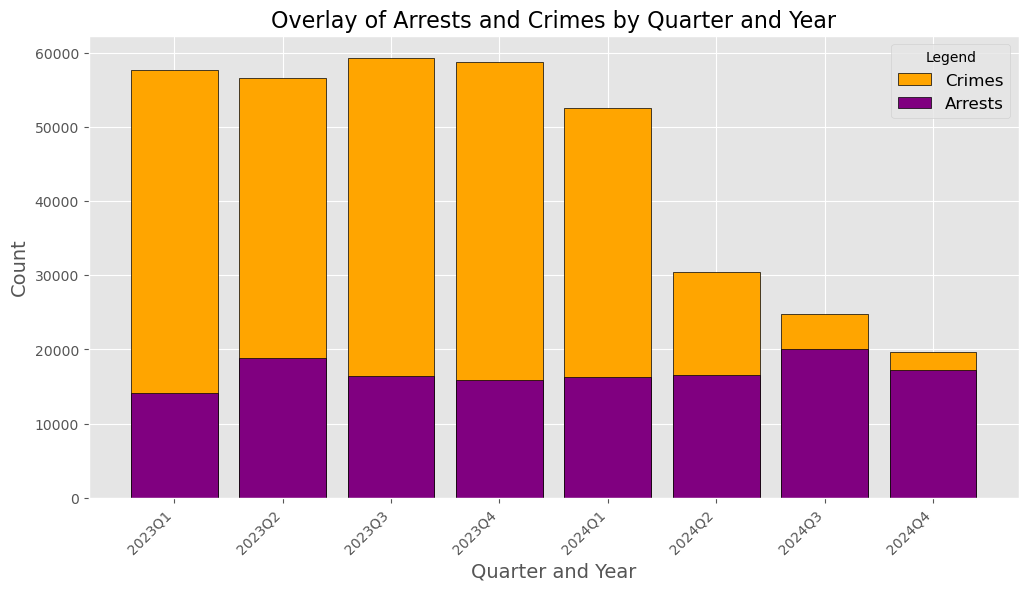

In [87]:
# view overlay of Arrests and Crimes by quarter and year

# Create 'Year_Quarter' for df_a_mod (Arrest Date)
if 'Year_Quarter' not in df_a_mod.columns:
    df_a_mod['Year_Quarter'] = pd.to_datetime(df_a_mod['Arrest Date']).dt.to_period('Q').astype(str)

# Create 'Year_Quarter' for df_cr_mod (DATE OCC)
if 'Year_Quarter' not in df_cr_mod.columns:
    df_cr_mod['Year_Quarter'] = pd.to_datetime(df_cr_mod['DATE OCC']).dt.to_period('Q').astype(str)

# Count the occurrences of each quarter for both datasets
arrest_counts = df_a_mod['Year_Quarter'].value_counts().sort_index()
crime_counts = df_cr_mod['Year_Quarter'].value_counts().sort_index()

# Create a DataFrame for plotting
data = pd.DataFrame({
    'Quarter': arrest_counts.index,
    'Arrests': arrest_counts.values,
    'Crimes': crime_counts.reindex(arrest_counts.index, fill_value=0).values  # align indices, fill missing with 0
})

# Plot the data with overlapping bars
plt.figure(figsize=(12, 6))

# Plot Crimes bars
plt.bar(data['Quarter'], data['Crimes'], color='orange', label='Crimes', edgecolor='black')

# Plot Arrests bars on top of Crimes bars
plt.bar(data['Quarter'], data['Arrests'], color='purple', label='Arrests', edgecolor='black')

# Add titles and labels
plt.title("Overlay of Arrests and Crimes by Quarter and Year", fontsize=16)
plt.xlabel('Quarter and Year', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
plt.legend(title='Legend', fontsize=12)

# Show the plot
plt.show()

Columns after merge:
Index(['Year_Quarter', 'Crime_Count', 'Arrest_Count', 'Foreclosure_Count'], dtype='object')


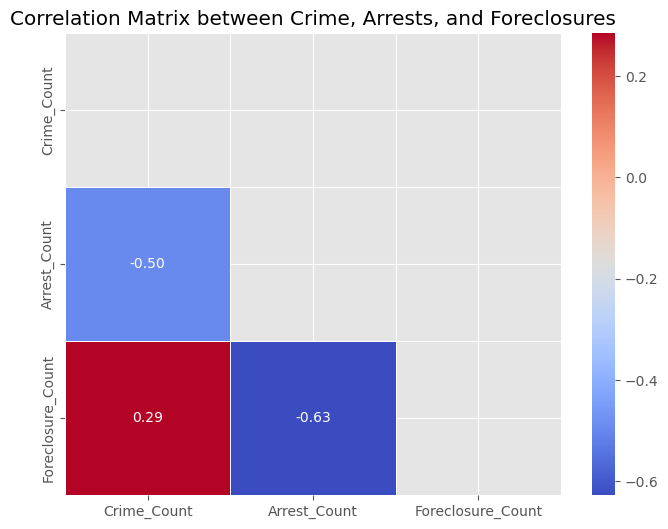

In [88]:
# Convert date columns to datetime format safely
df_a_mod['Arrest Date'] = pd.to_datetime(df_a_mod['Arrest Date'], errors='coerce')
df_a_mod['Year_Quarter'] = df_a_mod['Arrest Date'].dt.to_period('Q').astype(str)

df_cr_mod['DATE OCC'] = pd.to_datetime(df_cr_mod['DATE OCC'], errors='coerce')
df_cr_mod['Year_Quarter'] = df_cr_mod['DATE OCC'].dt.to_period('Q').astype(str)

df_fc_combined['Registered Date'] = pd.to_datetime(df_fc_combined['Registered Date'], errors='coerce')
df_fc_combined['Year_Quarter'] = df_fc_combined['Registered Date'].dt.to_period('Q').astype(str)

# Group by 'Year_Quarter'
arrest_counts = df_a_mod.groupby('Year_Quarter').size().reset_index(name='Arrest_Count')
crime_counts = df_cr_mod.groupby('Year_Quarter').size().reset_index(name='Crime_Count')
foreclosure_counts = df_fc_combined.groupby('Year_Quarter').size().reset_index(name='Foreclosure_Count')

# Merge datasets on Year_Quarter
df_corr_combined = pd.merge(crime_counts, arrest_counts, on='Year_Quarter', how='inner')
df_corr_combined = pd.merge(df_corr_combined, foreclosure_counts, on='Year_Quarter', how='inner')

# Debug: Print merged columns
print("Columns after merge:")
print(df_corr_combined.columns)

# Compute correlation matrix
corr_matrix = df_corr_combined[['Crime_Count', 'Arrest_Count', 'Foreclosure_Count']].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, mask=mask)
plt.title("Correlation Matrix between Crime, Arrests, and Foreclosures")
plt.show()

# Setup Athena Database

## Create Database

In [89]:
# Configuration of the athena |
region = boto3.Session().region_name
group_bucket = "ads508-group7"
database_name = "crime_foreclosure_db"
s3_staging_dir = f"s3://{group_bucket}/query-results/"
output_location = f"s3://{group_bucket}/final-joined/team7/"

# Connecting to athena
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)
cursor = conn.cursor()

# creation of the database
cursor.execute(f"CREATE DATABASE IF NOT EXISTS {database_name}")
print(f"Database '{database_name}' created or already exists.")

Database 'crime_foreclosure_db' created or already exists.


## Create tables in Athena

### The Arrests table



In [90]:
## The Arrests table
cursor.execute("DROP TABLE IF EXISTS crime_foreclosure_db.arrests_agg")

cursor.execute("""
CREATE EXTERNAL TABLE crime_foreclosure_db.arrests_agg (
    date string,
    area int,
    total_arrests int
)
ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
WITH SERDEPROPERTIES (
    'separatorChar' = ',',
    'quoteChar'     = '"',
    'serialization.null.format' = ''
)
LOCATION 's3://ads508-group7/Arrest/'
TBLPROPERTIES ('skip.header.line.count'='1')
""")
print("created 'arrests_agg' .")


created 'arrests_agg' .


### The Foreclosure table

In [91]:
## Foreclosure table
ddl_query = """
DROP TABLE IF EXISTS crime_foreclosure_db.foreclosures_agg;

CREATE EXTERNAL TABLE crime_foreclosure_db.foreclosures_agg (
    date STRING,
    area INT,
    total_foreclosures INT
)
ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe'
WITH SERDEPROPERTIES (
    'serialization.format' = ',',
    'field.delim' = ','
)
STORED AS TEXTFILE
LOCATION 's3://ads508-group7/Foreclosures/'
TBLPROPERTIES ('skip.header.line.count'='1');
"""

cursor = conn.cursor()
for statement in ddl_query.strip().split(";"):
    if statement.strip():
        cursor.execute(statement.strip())

print(" Table 'foreclosures_agg' created.")

 Table 'foreclosures_agg' created.


### The Crime table

In [92]:
# Crime Table
cursor.execute("DROP TABLE IF EXISTS crime_foreclosure_db.crime_agg")

cursor.execute("""
CREATE EXTERNAL TABLE crime_foreclosure_db.crime_agg (
    date string,
    area int,
    total_crimes int
)
ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
WITH SERDEPROPERTIES (
    'separatorChar' = ',',
    'quoteChar'     = '"',
    'serialization.null.format' = ''
)
LOCATION 's3://ads508-group7/Crime/'
TBLPROPERTIES ('skip.header.line.count'='1')
""")
print("Table 'crime_agg' created.")

Table 'crime_agg' created.


## Validating the setup

In [93]:
# List of tables to validate
agg_tables = ["arrests_agg", "crime_agg", "foreclosures_agg"]

# Step 1: Checking to make sure the tables were created
existing_tables = pd.read_sql("SHOW TABLES IN crime_foreclosure_db", conn)
print(" Tables in 'crime_foreclosure_db':")
display(existing_tables)

# Step 2: Preview first 5 rows of each table
for table in agg_tables:
    print(f"\n Preview of '{table}':")
    try:
        preview_df = pd.read_sql(f"SELECT * FROM crime_foreclosure_db.{table} LIMIT 5", conn)
        display(preview_df)
    except Exception as e:
        print(f" Error loading {table}: {e}")


/tmp/ipykernel_463/3415043242.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  existing_tables = pd.read_sql("SHOW TABLES IN crime_foreclosure_db", conn)


 Tables in 'crime_foreclosure_db':


,tab_name
0,arrests_agg
1,crime_agg
2,foreclosures_agg



 Preview of 'arrests_agg':


/tmp/ipykernel_463/3415043242.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  preview_df = pd.read_sql(f"SELECT * FROM crime_foreclosure_db.{table} LIMIT 5", conn)


,date,area,total_arrests
0,2023-01-01,1,10
1,2023-01-01,2,4
2,2023-01-01,3,9
3,2023-01-01,4,7
4,2023-01-01,5,5



 Preview of 'crime_agg':


/tmp/ipykernel_463/3415043242.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  preview_df = pd.read_sql(f"SELECT * FROM crime_foreclosure_db.{table} LIMIT 5", conn)


,date,area,total_crimes
0,2023-01-01,1,68
1,2023-01-01,2,49
2,2023-01-01,3,67
3,2023-01-01,4,50
4,2023-01-01,5,48



 Preview of 'foreclosures_agg':


/tmp/ipykernel_463/3415043242.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  preview_df = pd.read_sql(f"SELECT * FROM crime_foreclosure_db.{table} LIMIT 5", conn)


,date,area,total_foreclosures
0,2023-01-01,9,1
1,2023-01-01,17,1
2,2023-01-01,18,1
3,2023-01-02,3,2
4,2023-01-02,6,2


## Creating the final table by JOIN

In [94]:
# Query to join the aggregate tables into one using LEFT JOINs and replacing NULLs with 0
join_query = """
SELECT 
    a.date,
    a.area,
    a.total_arrests,
    c.total_crimes,
    f.total_foreclosures
FROM crime_foreclosure_db.arrests_agg a
LEFT JOIN crime_foreclosure_db.crime_agg c 
    ON a.date = c.date AND a.area = c.area
LEFT JOIN crime_foreclosure_db.foreclosures_agg f 
    ON a.date = f.date AND a.area = f.area
"""

# Load results into DataFrame
combined_agg = pd.read_sql(join_query, conn)

# Show preview
print("Join complete. Preview:")
print(combined_agg.head())

/tmp/ipykernel_463/3195326678.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  combined_agg = pd.read_sql(join_query, conn)


Join complete. Preview:
         date  area  total_arrests  total_crimes  total_foreclosures
0  2023-01-01     1             10         68.00                 NaN
1  2023-01-01     2              4         49.00                 NaN
2  2023-01-01     3              9         67.00                 NaN
3  2023-01-01     4              7         50.00                 NaN
4  2023-01-01     5              5         48.00                 NaN


In [95]:
## Replacing NAN/NULL with 0
combined_agg = combined_agg.fillna(0)

# Show preview
print(" Join complete. Preview (nulls replaced with 0):")
print(combined_agg.head())

 Join complete. Preview (nulls replaced with 0):
         date  area  total_arrests  total_crimes  total_foreclosures
0  2023-01-01     1             10         68.00                0.00
1  2023-01-01     2              4         49.00                0.00
2  2023-01-01     3              9         67.00                0.00
3  2023-01-01     4              7         50.00                0.00
4  2023-01-01     5              5         48.00                0.00


In [96]:
#update foreclosures to be a binary target variable. 1 for foreclosure happened, else 0

combined_agg['foreclosure_event'] = (combined_agg['total_foreclosures'] > 0).astype(int)

#drop total foreclosures
combined_agg = combined_agg.drop(columns=['total_foreclosures', 'date'])

#reorder so target first
target_col = 'foreclosure_event'
cols = [target_col] + [col for col in combined_agg.columns if col != target_col]
combined_agg = combined_agg[cols]

# Preview
print(combined_agg.head())

   foreclosure_event  area  total_arrests  total_crimes
0                  0     1             10         68.00
1                  0     2              4         49.00
2                  0     3              9         67.00
3                  0     4              7         50.00
4                  0     5              5         48.00


In [97]:
combined_agg['foreclosure_event'].value_counts()

foreclosure_event
0    13278
1     2015
Name: count, dtype: int64

In [98]:
## uploading the file to S3

combined_agg.to_csv("combined_agg.csv", index=False)

s3.upload_file(
    Filename="combined_agg.csv",
    Bucket="ads508-group7",
    Key="combined_data/combined_agg.csv"
)


## Split the Dataset

### Train and test set

In [99]:
len(combined_agg)

15293

In [ ]:

role = get_execution_role()
session = Session()

processor = SKLearnProcessor(
    framework_version="1.2-1",  
    role=role,
    instance_type="ml.t3.medium",
    instance_count=1
)

processor.run(
    code='split_data.py',
    inputs=[
        ProcessingInput(
            input_name='raw-input-data',
            source='s3://ads508-group7/combined_data/',
            destination='/opt/ml/processing/input'
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name='train-split',
            source='/opt/ml/processing/output_train',
            destination='s3://ads508-group7/splits/train'
        ),
        ProcessingOutput(
            output_name='val-split',
            source='/opt/ml/processing/output_val',
            destination='s3://ads508-group7/splits/val'
        ),
        ProcessingOutput(
            output_name='test-split',
            source='/opt/ml/processing/output_test',
            destination='s3://ads508-group7/splits/test'
        )
    ],
    logs=True,
    wait=True
)


[04/10/25 03:28:30] INFO     Defaulting to only available Python version: py3                     ]8;id=332515;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=280305;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#610\610]8;;\

[04/10/25 03:28:31] INFO     Creating processing-job with name                                      ]8;id=599265;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=524109;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1575\1575]8;;\
                             sagemaker-scikit-learn-2025-04-10-03-28-30-855                                        

...............

In [ ]:
# S3 paths
bucket = "ads508-group7"
prefixes = {
    "train": "splits/train/train.csv",
    "val": "splits/val/val.csv",
    "test": "splits/test/test.csv"
}

# Helper to load CSVs from S3
s3 = boto3.client("s3")

def load_csv_from_s3(bucket, key):
    obj = s3.get_object(Bucket=bucket, Key=key)
    return pd.read_csv(io.BytesIO(obj["Body"].read()))

# Load each split
train_df = load_csv_from_s3(bucket, prefixes["train"])
val_df = load_csv_from_s3(bucket, prefixes["val"])
test_df = load_csv_from_s3(bucket, prefixes["test"])

# Row counts
total_rows = len(train_df) + len(val_df) + len(test_df)
print(" Row Counts:")
print(f"Train: {len(train_df)} rows ({len(train_df)/total_rows:.1%})")
print(f"Validation: {len(val_df)} rows ({len(val_df)/total_rows:.1%})")
print(f"Test: {len(test_df)} rows ({len(test_df)/total_rows:.1%})")
print(f"Total: {total_rows} rows\n")

# Optional: Check column match and quick stat
print(" Columns in each split match:", 
      train_df.columns.equals(val_df.columns) and train_df.columns.equals(test_df.columns))

# Optional: Preview
print("\n Train sample:")
display(train_df.head())

## Modeling

In [ ]:
#sagemaker requires csvs without headers for training: https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-training.html
bucket = "ads508-group7"
paths = {
    "train": "xgb/train/train.csv",
    "val": "xgb/val/val.csv",
    "test": "xgb/test/test.csv"
}
#dataframes
split_dfs = {
    "train": train_df,
    "val": val_df,
    "test": test_df
}
#Remove headers and upload to S3
s3 = boto3.client("s3")

for split_name, df in split_dfs.items():
    csv_buffer = io.StringIO()
    df.to_csv(csv_buffer, index=False, header=False)
    s3.put_object(Bucket=bucket, Key=paths[split_name], Body=csv_buffer.getvalue())
    print(f"Uploaded {split_name} set to s3://{bucket}/{paths[split_name]}")

In [ ]:
#get sagemaker details
role = get_execution_role()
region = sagemaker.Session().boto_region_name
bucket = "ads508-group7"
#get built in sagemaker xgboost
xgboost_image_uri = sagemaker.image_uris.retrieve(
    framework="xgboost",
    region=region,
    version="1.5-1"  
)
#define xgboost estimator
xgb = Estimator(
    image_uri=xgboost_image_uri,
    role=role,
    instance_count=1,
    instance_type="ml.m5.large",  # Good balance of performance and cost
    output_path=f"s3://{bucket}/xgb/output/",
    sagemaker_session=sagemaker.Session()
)
#baseline hyperparamaters - will tune in later step
xgb.set_hyperparameters(
    objective="binary:logistic",
    eval_metric="auc",
    num_round=100  
)

### Hyperparamter Tuning

In [ ]:
#class ratio
scale_pos_weight = 13278 / 2015
scale_pos_weight

In [ ]:
#ChatGPT used to help troubleshoot hyperparamter tuning / learn about the ranges

#set up ranges
hyperparameter_ranges = {
    'max_depth': IntegerParameter(3, 10),
    'eta': ContinuousParameter(0.01, 0.3),
    'gamma': ContinuousParameter(0, 5),
    'min_child_weight': IntegerParameter(1, 10),
    'subsample': ContinuousParameter(0.5, 1.0),
}
#store best parameters
objective_metric_name = 'validation:auc'
objective_type = 'Maximize'

xgb.set_hyperparameters(
    objective="binary:logistic",
    eval_metric="auc",
    num_round=100,
    scale_pos_weight=6.589578163771712 
)

# Create a tuner using the XGBoost estimator
tuner = HyperparameterTuner(
    estimator=xgb,  
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=20,
    max_parallel_jobs=3,
    objective_type=objective_type,
    early_stopping_type='Auto'
)

In [ ]:
#start tuning job
from sagemaker.inputs import TrainingInput
tuner.fit({
    'train': TrainingInput(s3_data='s3://ads508-group7/xgb/train/', content_type='csv'),
    'validation': TrainingInput(s3_data='s3://ads508-group7/xgb/val/', content_type='csv')
})

print("Hyperparameter tuning job started")

In [ ]:
#create model 
tuner.wait()  # Wait until the tuning job is complete
best_estimator = tuner.best_estimator()
timestamp = int(time.time())
model_name = f"xgboost-foreclosure-model-{timestamp}"
model = best_estimator.create_model(name=model_name)
print(model_name)

In [ ]:
response = s3.head_object(Bucket=bucket_name, Key=model_key)
print(response.get('ServerSideEncryption'))

In [ ]:

# Define S3 bucket and model artifact details
bucket_name = 'ads508-group7'
model_key = 'xgb/output/sagemaker-xgboost-250407-0257-013-21d73408/output/model.tar.gz'
local_model_path = 'model.tar.gz'
# Initialize S3 client
s3 = boto3.client('s3')

# Download the model artifact
s3.download_file(bucket_name, model_key, local_model_path)

print(f"Model downloaded to {local_model_path}")

In [ ]:
import tarfile

# Extract the model.tar.gz file
with tarfile.open(local_model_path, 'r:gz') as tar:
    tar.extractall(path='model')
#get filename of model
print(os.listdir('model'))

In [ ]:
import xgboost as xgb

model = xgb.Booster()
model.load_model('model/xgboost-model')

In [ ]:
#get test dataset
bucket = 'ads508-group7'
test_file_key = 'xgb/test/test.csv'
local_test_file = 'test.csv'

s3 = boto3.client('s3')
s3.download_file(bucket, test_file_key, local_test_file)

df_test = pd.read_csv(local_test_file, header=None)
y_test = df_test.iloc[:, 0]
X_test = df_test.iloc[:, 1:]

In [ ]:
import xgboost as xgb
import numpy as np

# Convert test features into a DMatrix
dtest = xgb.DMatrix(X_test)

# Make predictions (output probabilities)
predictions = model.predict(dtest)

# Convert probabilities to binary predictions using threshold of 0.5
predicted_labels = (predictions > 0.5).astype(int)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score

# Calculate performance metrics
accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
roc_auc = roc_auc_score(y_test, predictions)  # Using probabilities for ROC AUC
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Display the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)